In [234]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers import legacy

try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [235]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0, 
                              patience=3, 
                              verbose=1,
                              restore_best_weights=True)

In [236]:
MAIN_DIR = "/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset"
train_dir = MAIN_DIR + "/Train"
test_dir = MAIN_DIR + "/Test"

In [237]:
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

3 directories and 1 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset'
2 directories and 2 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test'
0 directories and 93 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test/Defective'
0 directories and 101 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test/Not Defective'
2 directories and 2 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train'
0 directories and 401 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train/Non-Defective'
0 directories and 370 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train/Defective'
0 directories and 0 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/.ipynb_checkpoints'


In [7]:
img_size , batch_size, num_seed = (224,224), 32, 27

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

train_arg = {'batch_size':batch_size,
              'target_size':img_size,
              'class_mode':"binary",
              'shuffle':True,
              'seed':num_seed}

test_arg = {'batch_size':batch_size,
             'target_size':img_size,
             'class_mode':"binary",
             'shuffle':False,
             'seed':num_seed}

train_data = train_gen.flow_from_directory(
    directory=train_dir, subset='training', **train_arg)
valid_data = train_gen.flow_from_directory(
    directory=train_dir, subset='validation', **train_arg)
test_data = test_gen.flow_from_directory(
    directory=test_dir, **test_arg)

Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


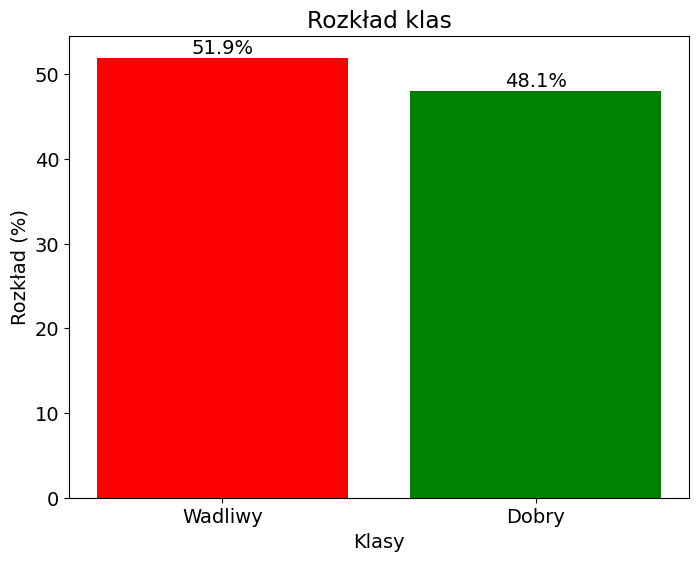

In [8]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 6))

labels = train_data.labels
count = pd.Series(labels).value_counts()

total_samples = len(labels)
percentages = count / total_samples * 100

bars = plt.bar(['Wadliwy', 'Dobry'], percentages, color=['red', 'green'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

plt.xlabel('Klasy')
plt.ylabel('Rozkład (%)')
plt.title('Rozkład klas')
plt.show()

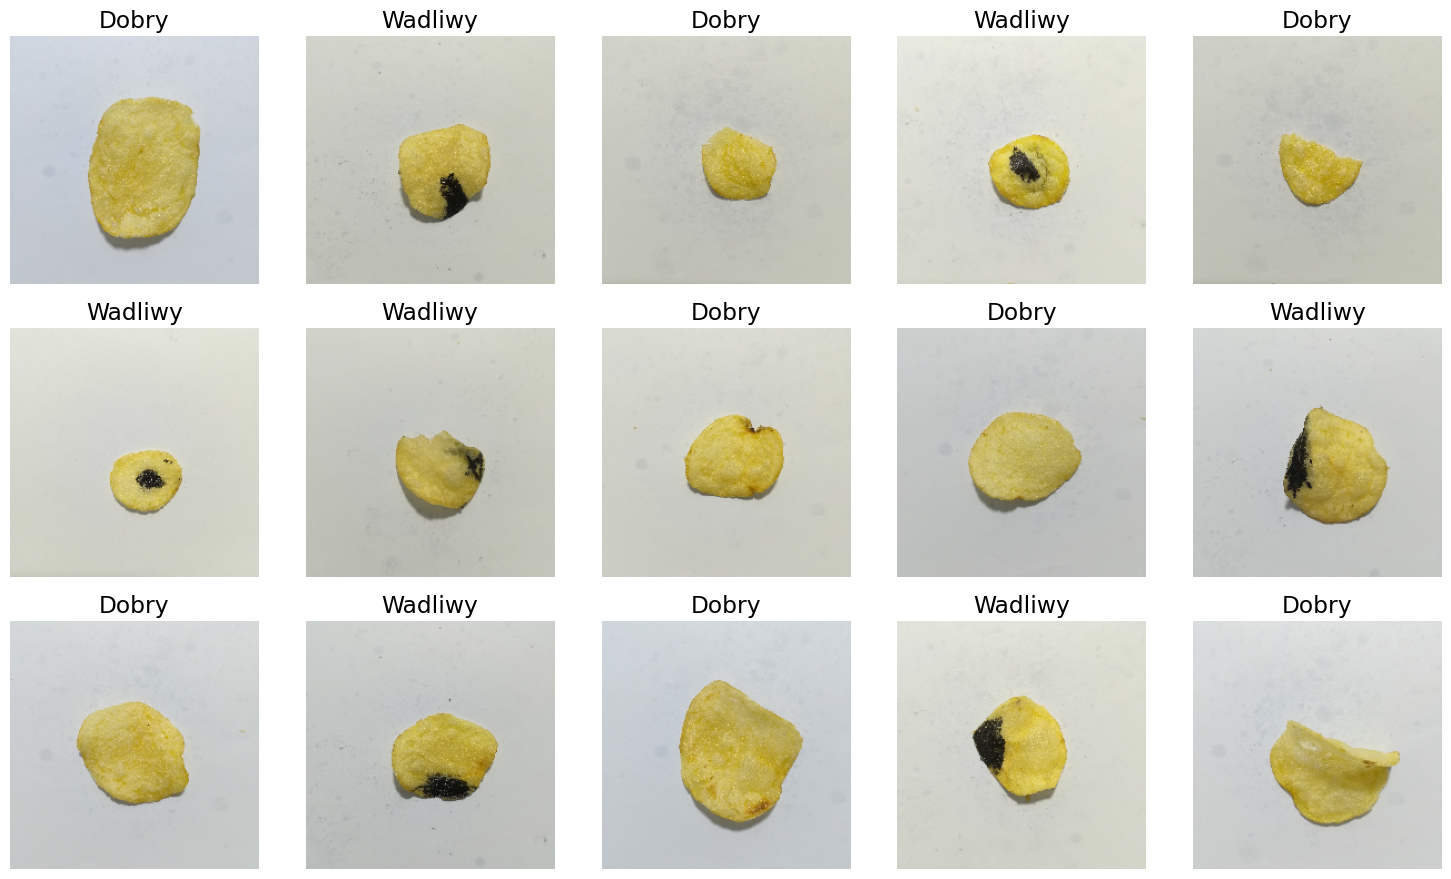

In [9]:
plt.figure(figsize=(15, 9))

# Liczba obrazów do wyświetlenia
num_images = 15

# Pobierz kolejne zestawy obrazów i etykiet
for i in range(num_images):
    x, y = train_data.next()
    axs = plt.subplot(3, 5, i + 1)
    plt.imshow(x[0])  # Wyświetl pierwszy obraz z zestawu
    plt.axis('off')
    axs.set_title("Wadliwy" if y[0] == 0 else "Dobry")
    axs.set_xticklabels([])
    axs.set_yticklabels([])

plt.tight_layout()
plt.show()

In [79]:
model_cnn = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 26, 26, 16)      

In [80]:
traininghistory = model_cnn.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
20/20 [==============================] - 44s 2s/step - loss: 0.7817 - accuracy: 0.5049 - val_loss: 0.6885 - val_accuracy: 0.5229
Epoch 2/5
20/20 [==============================] - 42s 2s/step - loss: 0.6287 - accuracy: 0.6234 - val_loss: 0.5069 - val_accuracy: 0.7190
Epoch 3/5
20/20 [==============================] - 42s 2s/step - loss: 0.2973 - accuracy: 0.9042 - val_loss: 0.1713 - val_accuracy: 0.9477
Epoch 4/5
20/20 [==============================] - 165s 9s/step - loss: 0.0873 - accuracy: 0.9838 - val_loss: 0.0618 - val_accuracy: 0.9804
Epoch 5/5
20/20 [==============================] - 43s 2s/step - loss: 0.0318 - accuracy: 0.9903 - val_loss: 0.0652 - val_accuracy: 0.9869


In [81]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="straty trenowania")
    plt.plot(epochs, val_loss, label="straty walidacji")
    plt.title("strata")
    plt.xlabel("epoki")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="dokładność trenowania")
    plt.plot(epochs, val_accuracy, label="dokładność walidacji")
    plt.title("dokładność")
    plt.xlabel("epoki")
    plt.legend()

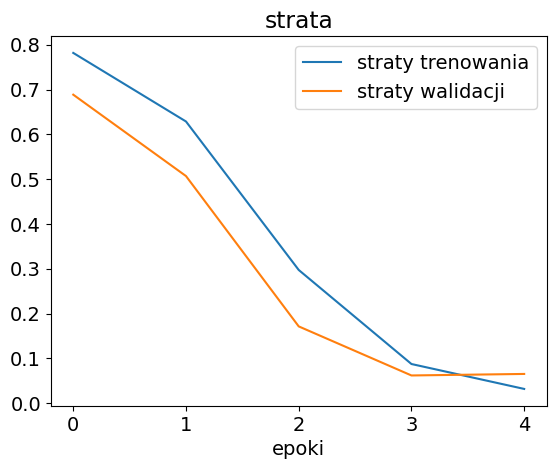

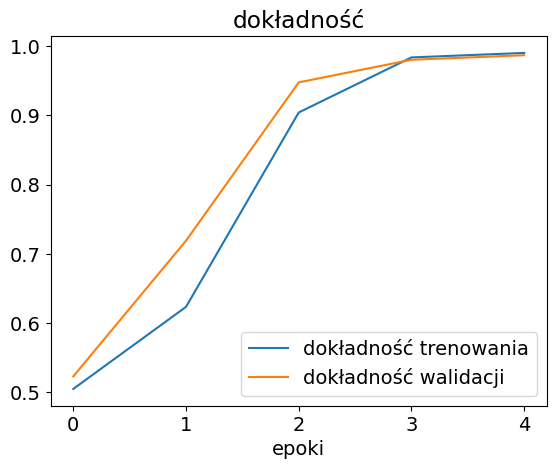

In [82]:
plot_curves(traininghistory)

In [83]:
result = model_cnn.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 100.00%
Loss: 0.0352


In [84]:
y_true = test_data.labels
y_pred = model_cnn.predict(test_data, verbose=0)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

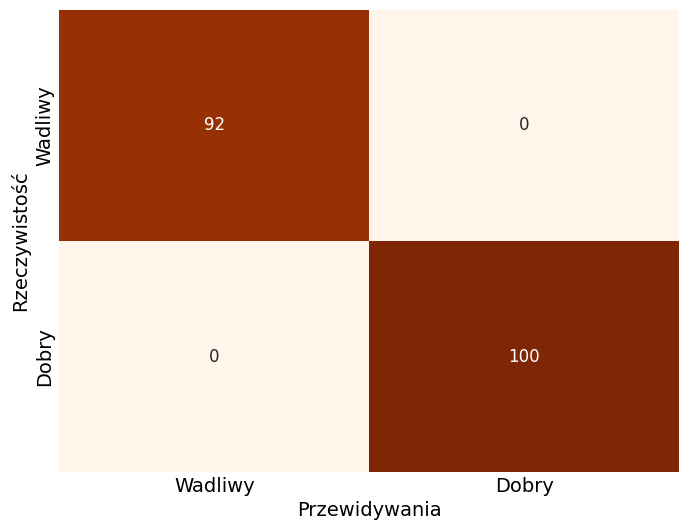

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true,y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [86]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        92
           1     1.0000    1.0000    1.0000       100

    accuracy                         1.0000       192
   macro avg     1.0000    1.0000    1.0000       192
weighted avg     1.0000    1.0000    1.0000       192

